In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bdi2_df = pd.read_csv('../data/NSS data_BDI2 scores_20200101-20230131_20241106.csv')

bdi2_df['testDate'] = pd.to_datetime(bdi2_df['testDate'])

bdi3_df = pd.read_excel('../data/NSS data_BDI3 Scores 20230101 20240630_Compiled_20241107.xlsx')

bdi3_df['Adaptive-Self Care Date of Testing'] = pd.to_datetime(bdi3_df['Adaptive-Self Care Date of Testing'])

eco_df = pd.read_excel('../data/NSS_ECO Data Ind 3 FFY 2023-24 20241211.xlsx',sheet_name='ECO with Exit23-24 ')

C:\Users\amerk\AppData\Local\Temp\ipykernel_5412\3923527380.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  bdi2_df = pd.read_csv('../data/NSS data_BDI2 scores_20200101-20230131_20241106.csv')


In [2]:
entry_exit = eco_df[(eco_df['OC1 Data Check']==1)][['CHILD_ID','BDI 3\nECO_Entry_DATE','BDI 3\nECO_Exit_DATE','BDI2 Entry Date']]

entry_exit.rename(columns={'CHILD_ID':'TEIDS Child ID'}, inplace=True)

entry_exit = entry_exit[(entry_exit['BDI 3\nECO_Exit_DATE'].notnull())&((entry_exit['BDI 3\nECO_Entry_DATE'].notnull())|(entry_exit['BDI2 Entry Date'].notnull()))]

In [3]:
bdi3_exit = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Exit_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

bdi3_entry = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Entry_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

bdi2_entry_subdomains = entry_exit.merge(bdi2_df,how='inner',left_on=['TEIDS Child ID','BDI2 Entry Date'],right_on=['Student TEIDS ID','testDate'])

bdi2_entry_subdomains = bdi2_entry_subdomains[~bdi2_entry_subdomains['testDate'].isnull()]

bdi2_entry = bdi2_df[bdi2_df['studentAssessmentID'].isin(bdi2_entry_subdomains['studentAssessmentID'])]

bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')

bdi3_entry = bdi3_entry[~bdi3_entry['Adaptive-Self Care Date of Testing'].isnull()]

bdi2_entry = bdi2_entry[['Student TEIDS ID','domainText','rawScore','DQScore','ZScore']]

bdi3_entry = bdi3_entry[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

bdi3_exit = bdi3_exit[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

C:\Users\amerk\AppData\Local\Temp\ipykernel_5412\3986738503.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')


In [4]:
# Dibran wrote this, don't praise me. -- Ryan
def transform_data(file)-> pd.DataFrame:
    df = file #This was originally where you would read in the csv for bdi-2, I changed it to run the already filtered dataframe -- Ryan
        #drop null student ID if you have any
    df = df[~df['Student TEIDS ID'].isnull()]
    # there are ids that have mulitple duplicate IDs example:526857
    #the following code will help deal with duplciate domain - allowing us to create more that 1 row if it has dup domain text
    df = df.sort_values(['Student TEIDS ID','domainText']).reset_index(drop=True)
    #sequential number to each row within a group
    df['row_number'] = df.groupby(['Student TEIDS ID', 'domainText']).cumcount()
    #pivot dataframe
    df_pivot = df.pivot_table(index=['Student TEIDS ID', 'row_number']
              , columns='domainText'
              , values=['rawScore','DQScore','ZScore']
              , aggfunc='first')
    #flatten multi-index columns
    df_pivot.columns = [f"{col[1]}-{col[0]}" for col in df_pivot.columns]
    #reset index
    df_pivot = df_pivot.reset_index()
    #drop row number
    df_pivot = df_pivot.drop(columns=['row_number'])
    return df_pivot

In [5]:
bdi2_df_test = transform_data(bdi2_entry)
bdi2_df_test

,Student TEIDS ID,Adaptive-DQScore,Cognitive-DQScore,Communication-DQScore,Motor-DQScore,Personal-Social-DQScore,Adaptive-ZScore,Adult Interaction-ZScore,Attention and Memory-ZScore,Cognitive-ZScore,...,Motor-rawScore,Peer Interaction-rawScore,Perception and Concepts-rawScore,Perceptual Motor-rawScore,Personal Responsibility-rawScore,Personal-Social-rawScore,Reasoning and Academic Skills-rawScore,Receptive Communication-rawScore,Self-Care-rawScore,Self-Concept and Social Role-rawScore
0,474848,75.0,63.0,55.0,90.0,70.0,-1.67,-2.00,-1.67,-2.47,...,77.0,NaN,8.0,NaN,NaN,33.0,NaN,11.0,23.0,10.0
1,474967,80.0,80.0,73.0,70.0,78.0,-1.33,-0.33,-2.00,-1.33,...,2.0,NaN,4.0,NaN,NaN,5.0,NaN,2.0,2.0,0.0
2,475907,90.0,73.0,78.0,85.0,85.0,-0.67,-0.67,-2.67,-1.80,...,5.0,NaN,4.0,NaN,NaN,6.0,NaN,6.0,3.0,2.0
3,476193,100.0,83.0,75.0,93.0,88.0,0.00,0.00,-1.33,-1.13,...,9.0,NaN,4.0,NaN,NaN,9.0,NaN,7.0,4.0,2.0
4,478004,85.0,73.0,75.0,80.0,80.0,-1.00,-1.33,-3.00,-1.80,...,7.0,NaN,6.0,NaN,NaN,7.0,NaN,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,543275,85.0,82.0,63.0,105.0,87.0,-1.00,0.00,-0.67,-1.20,...,112.0,12.0,16.0,18.0,6.0,88.0,10.0,25.0,36.0,30.0
2555,543279,80.0,80.0,56.0,93.0,78.0,-1.33,-1.67,-1.33,-1.33,...,82.0,NaN,13.0,NaN,NaN,44.0,NaN,17.0,26.0,17.0
2556,543285,80.0,77.0,75.0,91.0,82.0,-1.33,-1.33,-1.00,-1.53,...,97.0,7.0,10.0,10.0,4.0,62.0,8.0,24.0,28.0,22.0
2557,543286,65.0,73.0,57.0,83.0,73.0,-2.33,-2.00,-1.67,-1.80,...,74.0,NaN,12.0,NaN,NaN,40.0,NaN,14.0,22.0,14.0


In [6]:
test_ids = bdi3_exit[(bdi3_exit['TEIDS Child ID'].isin(bdi3_entry['TEIDS Child ID']))|(bdi3_exit['TEIDS Child ID'].isin(bdi2_entry['Student TEIDS ID']))]['TEIDS Child ID']

test_ids

bdi2_flag = pd.DataFrame({'TEIDS Child ID':bdi2_entry['Student TEIDS ID'].unique()})
bdi2_flag['bdi_flag'] = 2

bdi3_flag = pd.DataFrame(bdi3_entry['TEIDS Child ID'])
bdi3_flag['bdi_flag'] = 3

entry_flag = bdi2_flag.merge(bdi3_flag,how='outer',left_on=['TEIDS Child ID','bdi_flag'],right_on=['TEIDS Child ID','bdi_flag'])

In [7]:
1
exit_flagged = entry_flag.merge(bdi3_exit,how='inner',on='TEIDS Child ID')

bdi2_entry_exit = exit_flagged[exit_flagged['bdi_flag']==2]

bdi3_entry_exit = exit_flagged[exit_flagged['bdi_flag']==3]

In [8]:
bdi3_merge = bdi3_entry.merge(bdi3_entry_exit,how='inner',on='TEIDS Child ID',suffixes=("_entry","_exit"))

bdi3_oc1_e = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)
    &(bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']>-1.5)]

bdi3_oc1 = ['TEIDS Child ID','Social-Emotional Developmental Quotient_entry','Social-Emotional Developmental Quotient_exit','Social Emotional-Adult Interaction Z-Score_entry','Social Emotional-Adult Interaction Z-Score_exit','Social Emotional-Self Concept / Social Role Z-Score_entry','Social Emotional-Self Concept / Social Role Z-Score_exit','Social Emotional-Peer Interaction Z-Score_entry','Social Emotional-Peer Interaction Z-Score_exit','Social Emotional-Adult Interaction RS_entry','Social Emotional-Adult Interaction RS_exit','Social Emotional-Peer Interaction RS_entry','Social Emotional-Peer Interaction RS_exit','Social Emotional-Self Concept / Social Role RS_entry','Social Emotional-Self Concept / Social Role RS_exit']

bdi3_oc1_d = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
    |(((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
      &((bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Adult Interaction Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_exit']<=-1.5)))]

bdi3_oc1_c = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

bdi3_oc1_b = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

bdi3_oc1_a = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78)
    &(bdi3_merge['Social Emotional-Adult Interaction RS_exit']<=bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Peer Interaction RS_exit']<=bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']<=bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry'])]

In [9]:
aid3 = bdi3_oc1_a['TEIDS Child ID']

In [10]:
time_in_program = eco_df[['CHILD_ID','Days btw Initial and Exit','Days btw I-IFSP to Exit ECO','<Calc> Entrance Age (months)']]
time_in_program = time_in_program[time_in_program['Days btw Initial and Exit'] > 181]
time_in_program.loc[:, 'Years btw Initial and Exit'] = time_in_program['Days btw Initial and Exit'] / 365.2422
time_in_program.loc[:, 'Years btw I-IFSP to Exit ECO'] = time_in_program['Days btw I-IFSP to Exit ECO'] / 365.2422
time_in_program.loc[:, 'Age upon Exit (years)'] = (
    (time_in_program['<Calc> Entrance Age (months)']/12) + time_in_program['Years btw Initial and Exit']
)

exit_age = time_in_program[['CHILD_ID','Age upon Exit (years)']]

exit_age_a = exit_age[exit_age['CHILD_ID'].isin(aid3)]

exit_age_sorted = exit_age_a.sort_values(by='Age upon Exit (years)', ascending=False)

exit_age_sorted

,CHILD_ID,Age upon Exit (years)
1360,505750,5.990993
3215,526656,5.956755
6617,548484,5.076344
6429,546876,5.045031
6691,549176,4.951596
6706,549286,4.885036
6896,551084,4.789209
6245,545247,4.782883
7086,552972,4.746945
5792,542136,4.595510


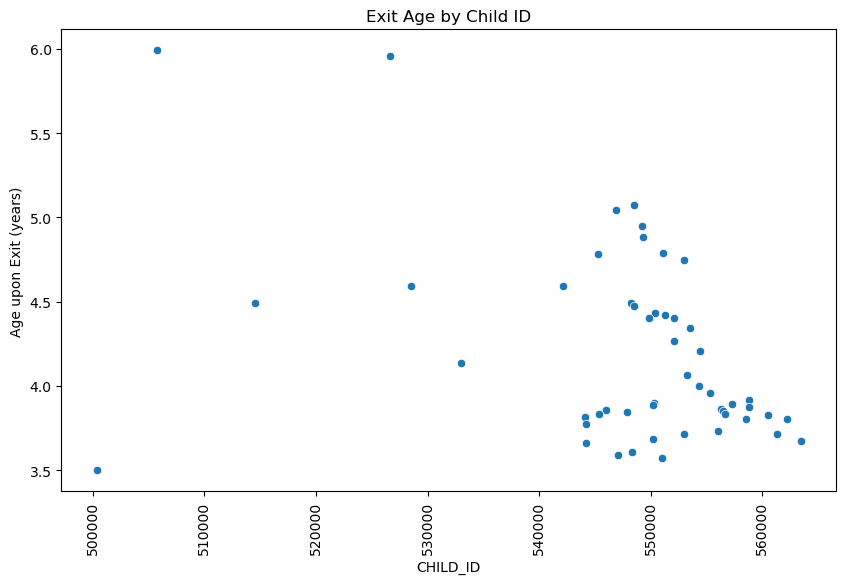

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=exit_age_sorted, x='CHILD_ID', y='Age upon Exit (years)')
plt.title("Exit Age by Child ID")
plt.xlabel("CHILD_ID")
plt.ylabel("Age upon Exit (years)")
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

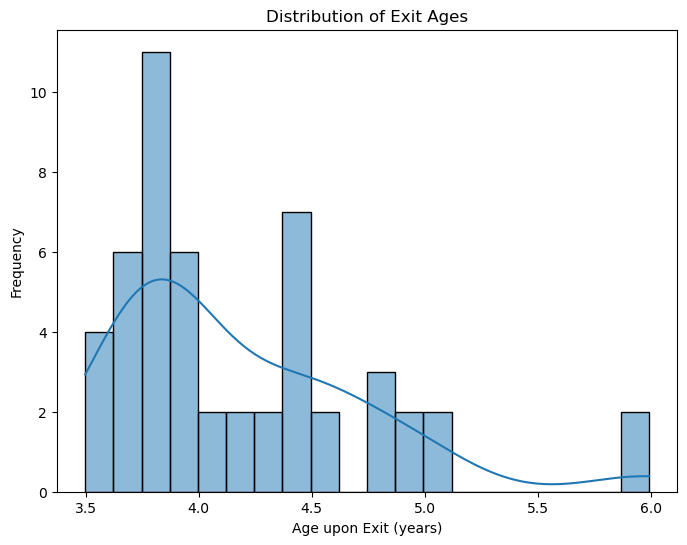

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(exit_age_sorted['Age upon Exit (years)'], bins=20, kde=True)
plt.title("Distribution of Exit Ages")
plt.xlabel("Age upon Exit (years)")
plt.ylabel("Frequency")
plt.show()

In [13]:
bdi3_eco_a = eco_df[eco_df['CHILD_ID'].isin(aid3)]

bdi3_eco_a['length_between_assessment'] = bdi3_eco_a['ECO_Exit_DATE'] - bdi3_eco_a['ECO_Entry_DATE']

bdi3_eco_diff = bdi3_eco_a[['CHILD_ID','length_between_assessment']]

bdi3_eco_diff = bdi3_eco_diff[bdi3_eco_diff['length_between_assessment'].dt.days>181]

C:\Users\amerk\AppData\Local\Temp\ipykernel_5412\2485871645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_eco_a['length_between_assessment'] = bdi3_eco_a['ECO_Exit_DATE'] - bdi3_eco_a['ECO_Entry_DATE']


In [14]:
# BDI3 - Category A - Time between between entry and exit assessments
bdi3_eco_diff = bdi3_eco_diff.sort_values(by='length_between_assessment', ascending=False)
bdi3_eco_diff

,CHILD_ID,length_between_assessment
1360,505750,715 days
3215,526656,668 days
6706,549286,401 days
5792,542136,395 days
6245,545247,377 days
6617,548484,369 days
6918,551280,349 days
7245,554281,334 days
6995,552063,330 days
2138,514559,326 days


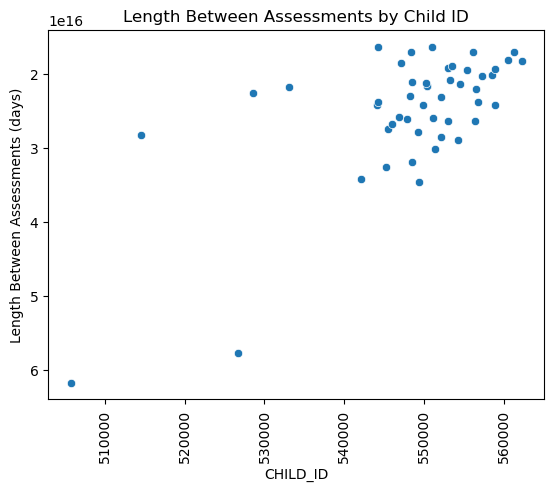

In [15]:
sns.scatterplot(data=bdi3_eco_diff, x='CHILD_ID', y='length_between_assessment')
plt.title("Length Between Assessments by Child ID")
plt.xlabel("CHILD_ID")
plt.ylabel("Length Between Assessments (days)")
plt.xticks(rotation=90)
plt.show()

In [16]:
bdi3_a_tip = time_in_program[time_in_program['CHILD_ID'].isin(aid3)]
bdi3_a_tip = bdi3_a_tip[['CHILD_ID','Days btw Initial and Exit']]
bdi3_a_tip = bdi3_a_tip.sort_values(by='Days btw Initial and Exit', ascending=False)

In [17]:
# BDI3 - Category A - Time between entry and exit
bdi3_a_tip

,CHILD_ID,Days btw Initial and Exit
1360,505750,1062
3215,526656,806
6245,545247,499
6429,546876,473
5792,542136,461
3505,528517,460
6585,548218,454
6617,548484,454
6706,549286,445
6827,550400,431


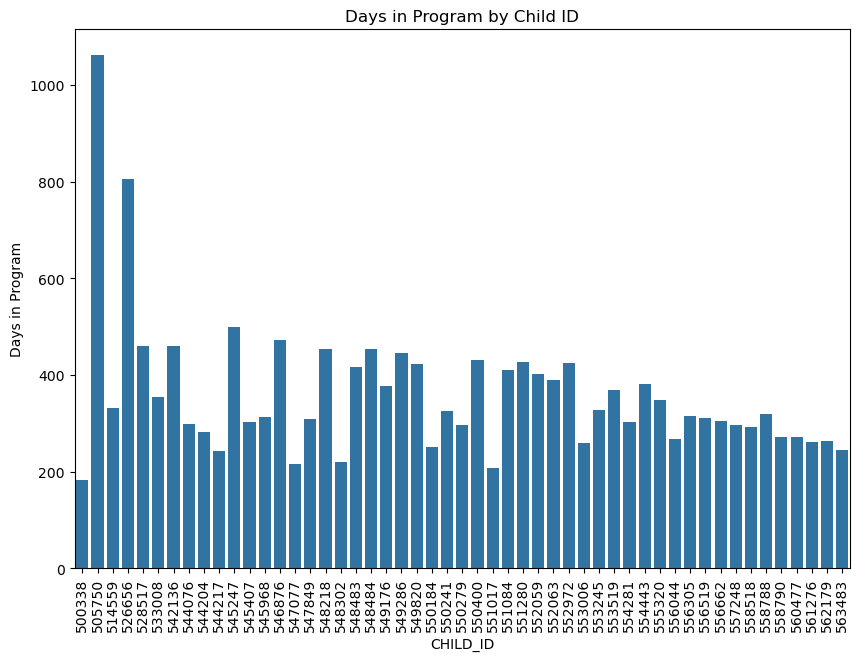

In [18]:
plt.figure(figsize=(10, 7))
sns.barplot(data=bdi3_a_tip, x='CHILD_ID', y='Days btw Initial and Exit')
plt.title("Days in Program by Child ID")
plt.xlabel("CHILD_ID")
plt.ylabel("Days in Program")
plt.xticks(rotation=90)  
plt.show()

C:\Users\amerk\AppData\Local\Temp\ipykernel_5412\3546917329.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=bdi3_a_tip, x='CHILD_ID', y='Days btw Initial and Exit', palette='viridis')


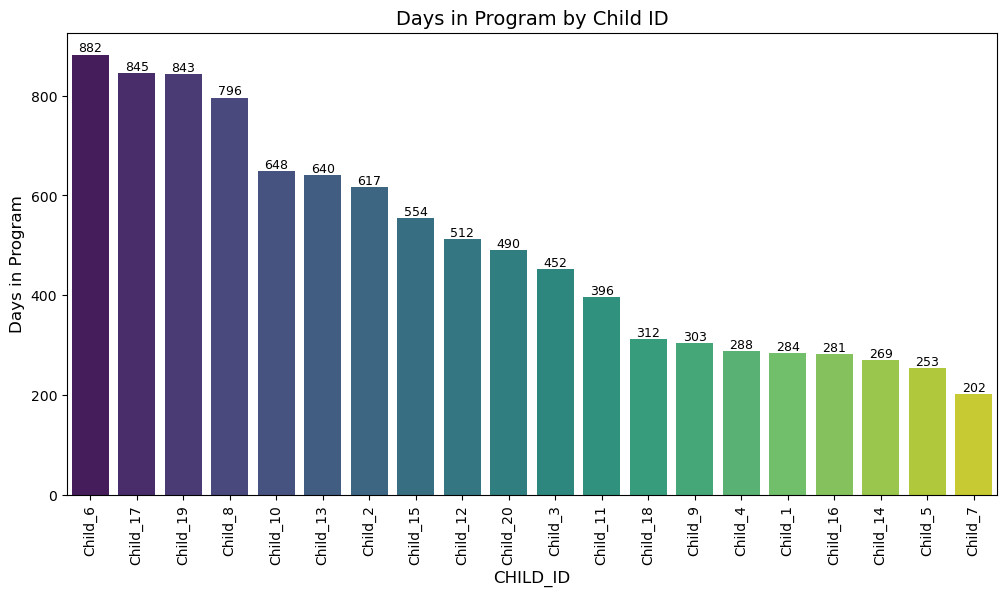

In [19]:
np.random.seed(42)
sample_size = 20
bdi3_a_tip = pd.DataFrame({
    'CHILD_ID': [f'Child_{i}' for i in range(1, sample_size + 1)],
    'Days btw Initial and Exit': np.random.randint(182, 1000, size=sample_size)  # Ensuring days > 181
})


bdi3_a_tip = bdi3_a_tip.sort_values(by='Days btw Initial and Exit', ascending=False)


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=bdi3_a_tip, x='CHILD_ID', y='Days btw Initial and Exit', palette='viridis')


for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')


plt.title("Days in Program by Child ID", fontsize=14)
plt.xlabel("CHILD_ID", fontsize=12)
plt.ylabel("Days in Program", fontsize=12)
plt.xticks(rotation=90) 


plt.show()









